In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

In [2]:
ascites = sc.read_h5ad("/mnt/c/Users/ouyangkang/Downloads/ascites_cancer_cell.h5ad")

In [3]:
ascites

AnnData object with n_obs × n_vars = 3009 × 40084
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes', 'doublet_score', 'predicted_doublet', 'chip_id', '_scvi_batch', '_scvi_labels', 'P_celltypist', 'clinic_info', 'leiden', 'ptprc_proportion'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'P_celltypist_colors', '_scvi_manager_uuid', '_scvi_uuid', 'chip_id_colors', 'clinic_info_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

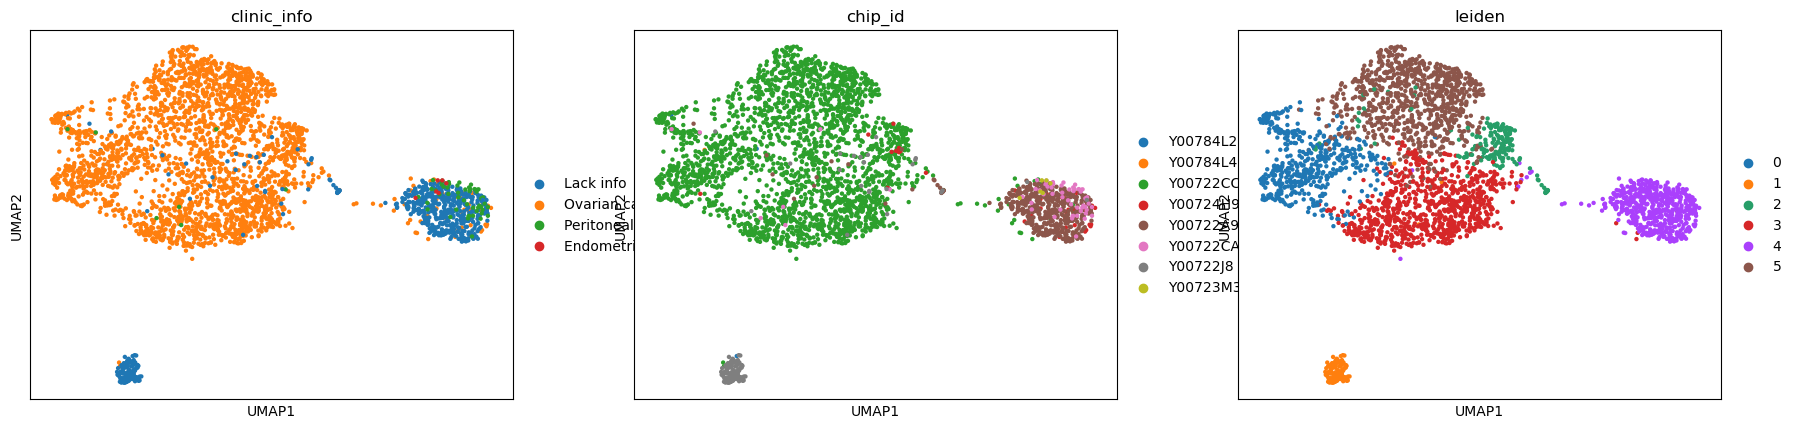

In [4]:
sc.pl.umap(ascites, color=['clinic_info', 'chip_id', 'leiden'])

In [17]:
def kegg_enrichment(gene_list, file_name_prefix):
    # enrichment analysis
    enr = gp.enrich(gene_list,
                    gene_sets="GO_Molecular_Function_2025",
                    outdir=None)
    # filtering p value is more than 0.05
    result = enr.res2d[enr.res2d['Adjusted P-value'] < 0.05]
    # save result
    result.to_csv(f"/mnt/c/Users/ouyangkang/Desktop/{file_name_prefix}_result.csv", index=None)

    return result

In [6]:
# DEGs extraction
result = ascites.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [7]:
degs.head()

,0_names,0_scores,0_pvals,0_pvals_adj,0_logfoldchanges,1_names,1_scores,1_pvals,1_pvals_adj,1_logfoldchanges,...,4_names,4_scores,4_pvals,4_pvals_adj,4_logfoldchanges,5_names,5_scores,5_pvals,5_pvals_adj,5_logfoldchanges
0,KIAA1217,22.259529,9.120053e-110,3.655682e-105,1.836437,AC105402.3,16.912422,3.644226e-64,8.183729e-60,6.612270,...,CCDC80,33.534149,1.532831e-246,6.144201e-242,6.280094,RPS16,27.820562,2.446779e-170,9.807667e-166,1.466644
1,MAML2,21.233894,4.644921e-100,6.206234e-96,1.335056,RN7SKP255,16.905716,4.083290e-64,8.183729e-60,4.049450,...,DPYD,32.729248,5.993081e-235,1.201133e-230,5.372569,RPS27,27.660604,2.080619e-168,4.169976e-164,1.196584
2,ALCAM,20.927933,2.981451e-97,2.390170e-93,1.685094,RN7SL5P,16.737226,7.018195e-63,9.377244e-59,3.874691,...,IL1R1,32.620247,2.117948e-233,2.829860e-229,5.104749,FTH1,27.565575,2.879480e-167,3.847370e-163,1.579001
3,TBL1XR1,20.574158,4.677769e-94,2.678624e-90,1.570851,RN7SL4P,15.123882,1.126971e-51,1.129337e-47,5.391565,...,ZEB2,32.605598,3.416299e-233,3.423474e-229,5.069376,RPL11,26.585581,9.965751e-156,9.986679e-152,1.148185
4,ITGB8,19.664196,4.370349e-86,1.751811e-82,1.576149,PLCG2,14.474105,1.766105e-47,1.415851e-43,1.969988,...,C3,32.488754,1.537153e-231,1.026921e-227,5.332978,RPL36A,26.495897,1.080688e-154,8.663657e-151,1.554346


In [13]:
tmp_dir = {}
for i in range(6):
    idx = str(i)
    tem_df = degs[degs.columns[degs.columns.str.contains(idx)]]
    tem_df = tem_df[tem_df[idx + "_logfoldchanges"] > 0]
    tem_df = tem_df[tem_df[idx + "_pvals_adj"] < 0.05]
    key = i
    tmp_dir[key] = tem_df[idx + "_names"].tolist()

In [22]:
# create a empty list to temporarily save result data frame
result_list = []
for i in range(6):
    part_genes = tmp_dir[i]
    result = kegg_enrichment(part_genes, str(i))
    result["group"] = i
    result_list += [result]

final_result = pd.concat(result_list, ignore_index=True)

In [14]:
ascites.obs['category'] = [1 if i == '4' else 0 for i in ascites.obs['leiden']]

In [16]:
res = gp.gsea(data=ascites.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=ascites.obs.category,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/gsea.py:110: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True, ddof=0)


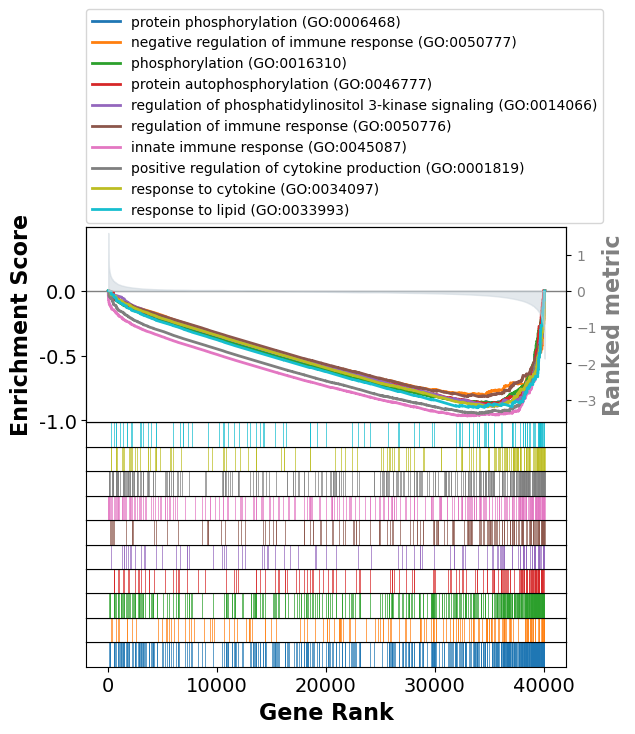

In [21]:
term = res.res2d.Term
axs = res.plot(terms=term[:10])

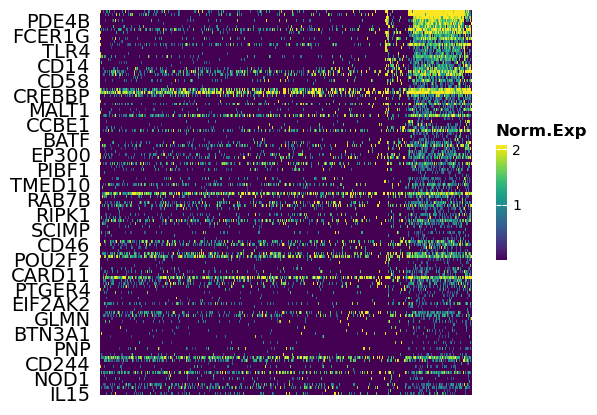

In [31]:
i = 7
genes = res.res2d.Lead_genes.iloc[i].split(";")
ax = gp.heatmap(df = res.heatmat.loc[genes],
           z_score=None,
           title=None,
           figsize=(6,5),
           cmap=plt.cm.viridis,
           xticklabels=False)

In [23]:
term[:10]

0                 protein phosphorylation (GO:0006468)
1    negative regulation of immune response (GO:005...
2                         phosphorylation (GO:0016310)
3             protein autophosphorylation (GO:0046777)
4    regulation of phosphatidylinositol 3-kinase si...
5           regulation of immune response (GO:0050776)
6                  innate immune response (GO:0045087)
7    positive regulation of cytokine production (GO...
8                    response to cytokine (GO:0034097)
9                       response to lipid (GO:0033993)
Name: Term, dtype: object

In [24]:
term[4]

'regulation of phosphatidylinositol 3-kinase signaling (GO:0014066)'

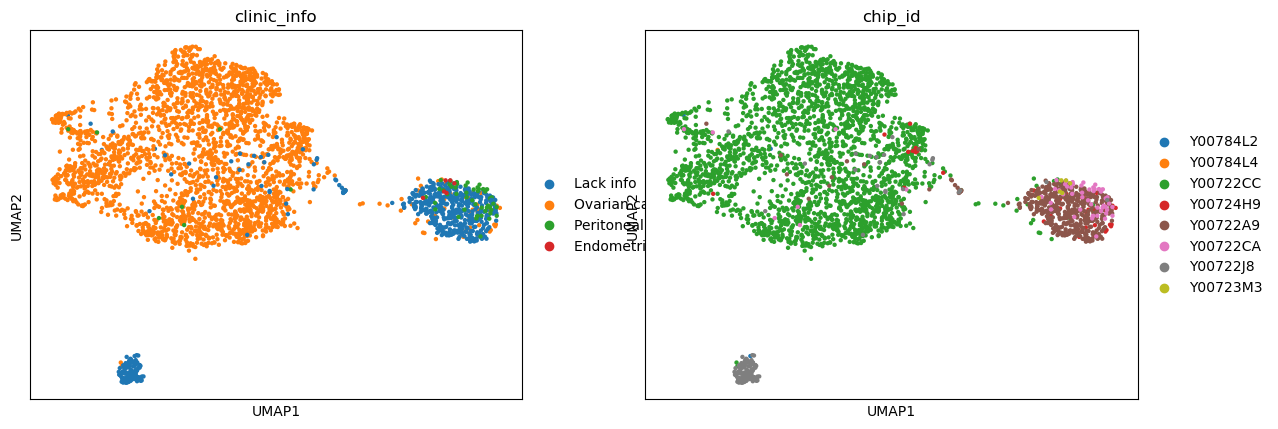

In [32]:
sc.pl.umap(ascites, color=['clinic_info', 'chip_id'])

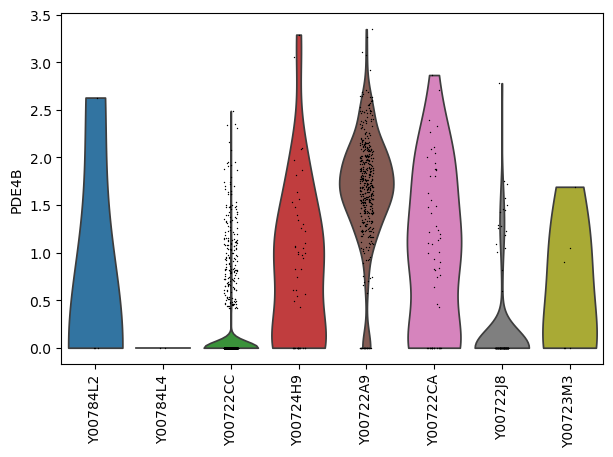

In [29]:
sc.pl.violin(ascites, ['PDE4B'], groupby='chip_id', rotation=90)

<Axes: xlabel='chip_id'>

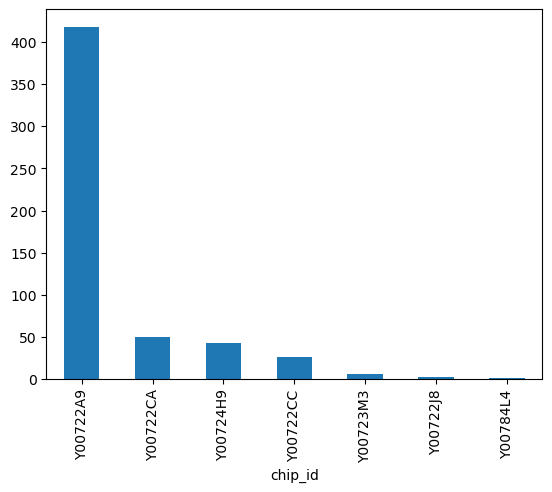

In [40]:
ascites[ascites.obs[ascites.obs['leiden'] == '4'].index, :].obs['chip_id'].value_counts().plot(rot=90, kind='bar')

In [70]:
pde_score = ascites[:, 'PDE4B'].X.todense() / ascites.X.sum(axis=1)
min_val = np.min(pde_score)
max_val = np.max(pde_score)

scale_score = 2 * (pde_score - min_val) / (max_val - min_val) - 1

ascites.obs['pde_score']= scale_score

In [76]:
chip_id = list(ascites.obs['chip_id'].unique())
clinic_info = ['Unknown', 'Unknown', 'OC', 'OC', 'Unknown', 'Unknown', 'OC', 'EC']
print(chip_id)

['Y00784L2', 'Y00784L4', 'Y00722CC', 'Y00724H9', 'Y00722A9', 'Y00722CA', 'Y00722J8', 'Y00723M3']


In [78]:
score = []
for chip in chip_id:
    tmp_adata = ascites[ascites.obs[ascites.obs['chip_id'] == chip].index, :]
    chip_score = tmp_adata[:, 'PDE4B'].X.sum() / tmp_adata.X.sum()
    score.append(chip_score)

In [83]:
df = pd.DataFrame([clinic_info, score])
df = df.T
df.head()

,0,1
0,Unknown,0.000405
1,Unknown,0.0
2,OC,0.000031
3,OC,0.000241
4,Unknown,0.000393


/tmp/ipykernel_1277/938131482.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=0, y=1, data=df, palette='Set1')


<Axes: xlabel='0', ylabel='1'>

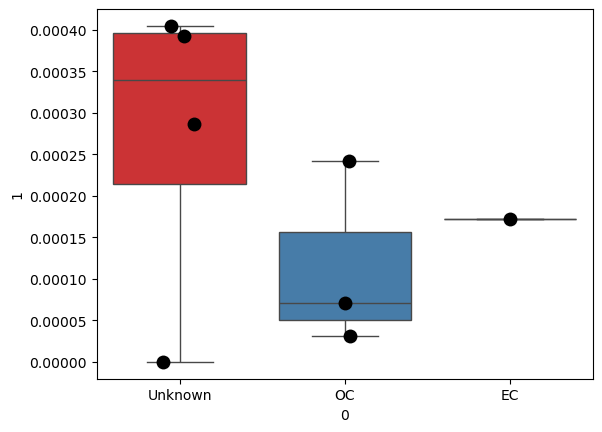

In [92]:
import seaborn as sns

sns.boxplot(x=0, y=1, data=df, palette='Set1')
sns.stripplot(x=0, y=1, data=df, jitter=True, color="black", size=10)

## cancer type heterogeneity

In [5]:
ascites.obs['clinic_info'].unique()

['Lack info', 'Ovarian cancer', 'Peritoneal metastases', 'Endometrial cancer']
Categories (4, object): ['Lack info', 'Ovarian cancer', 'Peritoneal metastases', 'Endometrial cancer']

In [6]:
ascites = ascites[ascites.obs[ascites.obs['clinic_info'].isin(['Ovarian cancer', 'Endometrial cancer'])].index, :]

In [7]:
sc.tl.rank_genes_groups(ascites, groupby='clinic_info')

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


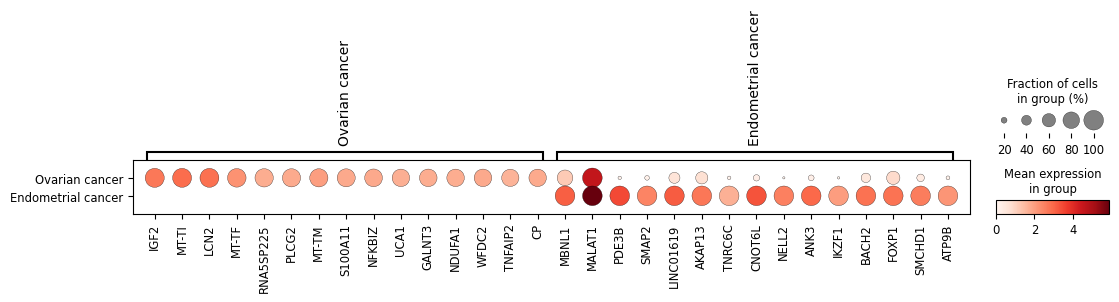

In [11]:
sc.pl.rank_genes_groups_dotplot(ascites, groupby='clinic_info', n_genes=15)